# Projet télédétection
Audrey Zimmer

Zone d'étude : Bretagne 2023 - 2024

Objectif : 

## 1. Import des librairies

In [43]:
# Librairies python
import sys
sys.path.append('..')
import os
from sklearn.model_selection import train_test_split
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from sklearn import tree
from sklearn.metrics import confusion_matrix, classification_report, \
    accuracy_score
import geopandas as gpd
from osgeo import ogr
from osgeo import gdal
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedStratifiedKFold, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


# Librairies personnelles
from libsigma import classification as cla
from libsigma import read_and_write as rw
from libsigma import plots


## Création des dossiers

In [ ]:
# Chemin de base (absolu)
my_folder = "/home/onyxia/work/Projet_teledetection"


# Chemins des dossiers à créer (absolus)
results_path = os.path.join(my_folder, "../results")
figure_path = os.path.join(my_folder, "../results/figure")
img_path = os.path.join(my_folder, "img")


# Création des dossiers
os.makedirs(results_path, exist_ok=True)
os.makedirs(figure_path, exist_ok=True)
os.makedirs(img_path, exist_ok=True)

print("Dossiers results, figure et img créés avec succès !")


# Paramètres
dates = ['19-07-2024', '07-06-2024', '18-04-2024', '19-01-2024', '08-10-2023']
bandes = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']


# Fichiers d'entrée 
path_b3 = "/home/onyxia/work/data/projet_eval/bretagne_23-24_B03.tif" 
path_b5 = "/home/onyxia/work/data/projet_eval/bretagne_23-24_B05.tif"
path_vecteur = "/home/onyxia/work/data/projet_eval/PI_strates_bretagne_32630.shp"


print("Configuration prête. Les sorties seront définies dans les blocs suivants.")


Dossiers results, figure et img créés avec succès !


## Formatage des données

In [ ]:
# Dictionnaire pour stocker les datasets
datasets = {}

# Vérification des dimensions
for bande in bandes:
    chemin = f'/home/onyxia/work/data/projet_eval/bretagne_23-24_{bande}.tif'
    
    # 1. Ouverture de l'image et stockage dans dataset 
    datasets[bande] = rw.open_image(chemin)
    
    print(f"Bande {bande}:")
    
    # 2. Obtention des informations de colonnes, de lignes et de bandes des données
    rw.get_image_dimension(datasets[bande], verbose=True)
    print("-" * 20) # Séparateur pour la lisibilité

Bande B02:
Number of columns : 1533
Number of lines : 612
Number of bands : 5
--------------------
Bande B03:
Number of columns : 1533
Number of lines : 612
Number of bands : 5
--------------------
Bande B04:
Number of columns : 1533
Number of lines : 612
Number of bands : 5
--------------------
Bande B05:
Number of columns : 1533
Number of lines : 612
Number of bands : 5
--------------------
Bande B06:
Number of columns : 1533
Number of lines : 612
Number of bands : 5
--------------------
Bande B07:
Number of columns : 1533
Number of lines : 612
Number of bands : 5
--------------------
Bande B08:
Number of columns : 1533
Number of lines : 612
Number of bands : 5
--------------------
Bande B8A:
Number of columns : 1533
Number of lines : 612
Number of bands : 5
--------------------
Bande B11:
Number of columns : 1533
Number of lines : 612
Number of bands : 5
--------------------
Bande B12:
Number of columns : 1533
Number of lines : 612
Number of bands : 5
--------------------


Toutes les bandes obtenues ont la même dimension : 
- 1533 colonnes
- 612 lignes
- 5 bandes

## Analyse des échantillons
### Nombre d'échantillons

In [ ]:
# Calcul de l'emprise spatiale des données 

# 1. Ouvrir l'image de référence
ds = rw.open_image(path_b3)

# 2. Récupérer les dimensions (Lignes, Colonnes)
nb_lignes, nb_col, _ = rw.get_image_dimension(ds)

# 3. Récupérer l'origine (X_min, Y_max)
# Dans GDAL, l'origine est le coin SUPÉRIEUR gauche
origin_x, origin_y = rw.get_origin_coordinates(ds)

# 4. Récupérer la taille du pixel
# psize_y est généralement négatif car on descend dans l'image
psize_x, psize_y = rw.get_pixel_size(ds)

# 5. Calculer les bornes de l'emprise
x_min = origin_x
x_max = origin_x + (nb_col * psize_x)

y_max = origin_y
y_min = origin_y + (nb_lignes * psize_y) 

# Affichage des résultats
print("--- Emprise des données ---")
print(f"X Min (Ouest) : {x_min:.2f}")
print(f"X Max (Est)   : {x_max:.2f}")
print(f"Y Min (Sud)   : {y_min:.2f}")
print(f"Y Max (Nord)  : {y_max:.2f}")
print("-" * 27)

In [ ]:
# --- ANALYSE DES ÉCHANTILLONS ---

# 1. Chargement du fichier
gdf = gpd.read_file(path_vecteur)

# 2. Préparation des données pour le diagramme
polygon_counts = gdf['strate'].value_counts().reset_index()
polygon_counts.columns = ['Classe', 'Nombre de polygones']
polygon_counts['Classe'] = polygon_counts['Classe'].astype(str)

# On s'assure d'avoir les 4 classes pour la cohérence visuelle
all_classes = pd.DataFrame({'Classe': ['1', '2', '3', '4']})
polygon_counts = all_classes.merge(polygon_counts, on='Classe', how='left').fillna(0)
polygon_counts['Nom'] = polygon_counts['Classe'].map({'1': 'Sol nu', '2': 'Herbe', '3': 'Landes', '4': 'Arbre'})

# 3. Création du diagramme de répartition
fig_polygons = px.bar(
    polygon_counts,
    x='Classe',
    y='Nombre de polygones',
    color='Classe',
    color_discrete_map={'1': '#F5DEB3', '2': '#98FB98', '3': '#32CD32', '4': '#228B22'},
    title='Répartition des polygones d\'échantillonnage par classe',
    hover_data=['Nom'],
    category_orders={'Classe': ['1', '2', '3', '4']}
)

fig_polygons.update_xaxes(tickvals=['1', '2', '3', '4'], ticktext=['Sol nu', 'Herbe', 'Landes', 'Arbre'])

# 4. Enregistrement
output_polygon_html = os.path.join(figure_path, 'diag_baton_nb_poly_by_class.html')
fig_polygons.write_html(output_polygon_html)
fig_polygons.show()

print(f"Analyse des échantillons terminée. Nombre total de polygones : {len(gdf)}")

Analyse des échantillons terminée. Nombre total de polygones : 278


La classe 1 (sol nu) est absente des 

### Nombre de pixels par classe

In [ ]:
# --- Rasterisation ---

# 1. Définition du fichier de sortie (Ici et maintenant)
output_strates_raster = os.path.join(results_path, "PI_strates_bretagne_32630_raster.tif")

# 2. Paramètres de l'emprise (déjà calculés)
xmin, ymin, xmax, ymax = 432950.0, 5362770.0, 448280.0, 5368890.0 # Emprise du raster calculée précédemment
res = 10 # Résolution 10m

# 3. Commande de rasterisation
cmd = (f"gdal_rasterize -a strate -tr {res} {res} "
       f"-te {xmin} {ymin} {xmax} {ymax} -ot Byte -of GTiff "
       f"{path_vecteur} {output_strates_raster}")

print(f"Création de : {output_strates_raster}")
os.system(cmd)

if os.path.exists(output_strates_raster):
    print("Le masque des strates est prêt.")

In [ ]:
# --- NOMBRE DE PIXELS PAR STRATE ---

# 1. Chargement du raster que tu viens de créer au Bloc 3
# On utilise ta fonction rw pour charger l'image en array
raster_array = rw.load_img_as_array(output_strates_raster)

# 2. Comptage des pixels par classe
unique, counts = np.unique(raster_array, return_counts=True)
pixel_counts = dict(zip(unique, counts))

# Exclure la classe 0 (fond/NoData)
pixel_counts.pop(0, None)

# 3. Création du DataFrame de synthèse
all_classes = pd.DataFrame({'Classe': [1, 2, 3, 4]})
pixel_df = pd.merge(
    all_classes,
    pd.DataFrame({'Classe': list(pixel_counts.keys()), 'Nombre de pixels': list(pixel_counts.values())}),
    on='Classe',
    how='left'
).fillna(0)

# 4. Configuration visuelle
color_map = {1: '#F5DEB3', 2: '#98FB98', 3: '#32CD32', 4: '#228B22'}
noms_strates_complet = {1: 'Sol nu', 2: 'Herbe', 3: 'Landes', 4: 'Arbre'}

# 5. Création du graphique unique et homogène
fig_pixels = go.Figure()

for classe in pixel_df['Classe']:
    count = pixel_df[pixel_df['Classe'] == classe]['Nombre de pixels'].values[0]
    fig_pixels.add_trace(go.Bar(
        x=[classe],
        y=[count],
        marker_color=color_map[classe],
        name=noms_strates_complet[classe],
        text=int(count), # Affiche le nombre au-dessus de la barre
        textposition='auto',
    ))

# Mise à jour du design
fig_pixels.update_layout(
    title='Distribution spatiale : Nombre de pixels par classe',
    xaxis_title='Type de strate',
    yaxis_title='Nombre de pixels',
    xaxis=dict(
        tickvals=[1, 2, 3, 4],
        ticktext=['Sol nu', 'Herbe', 'Landes', 'Arbre'],
        type='category'
    ),
    template='plotly_white',
    showlegend=True
)

# 6. Enregistrement (Utilise le chemin figure_path défini au Bloc 1)
output_pixel_html = os.path.join(figure_path, 'diag_baton_nb_pix_by_class.html')
fig_pixels.write_html(output_pixel_html)

# Affichage
fig_pixels.show()

print(f"Statistiques de pixels sauvegardées dans : {output_pixel_html}")

✅ Statistiques de pixels sauvegardées dans : /home/onyxia/work/results/figure/diag_baton_nb_pix_by_class.html


## Phénologie des strates, mise en évidence des landes

In [ ]:
# --- Calcul ARI ---

# 1. Définition du fichier de sortie
output_ari_path = os.path.join(results_path, "ARI_serie_temp.tif")

# 2. Chargement des données via rw
print("Chargement des bandes...")
arr_b3 = rw.load_img_as_array(path_b3).astype(np.float32)
arr_b5 = rw.load_img_as_array(path_b5).astype(np.float32)

# 3. Calcul mathématique
with np.errstate(divide='ignore', invalid='ignore'):
    # Formule ARI : ((1/B03)-(1/B05)) / ((1/B03)+(1/B05))
    inv_b3 = 1.0 / arr_b3
    inv_b5 = 1.0 / arr_b5
    ari_stack = (inv_b3 - inv_b5) / (inv_b3 + inv_b5)

# Nettoyage NoData
ari_stack = np.nan_to_num(ari_stack, nan=-9999, posinf=-9999, neginf=-9999)

# 4. Écriture avec rw
ds_ref = rw.open_image(path_b3)
rw.write_image(output_ari_path, ari_stack, data_set=ds_ref, gdal_dtype=gdal.GDT_Float32)

print(f"ARI enregistré : {output_ari_path}")

Chargement des bandes...
ARI enregistré : /home/onyxia/work/results/ARI_serie_temp.tif


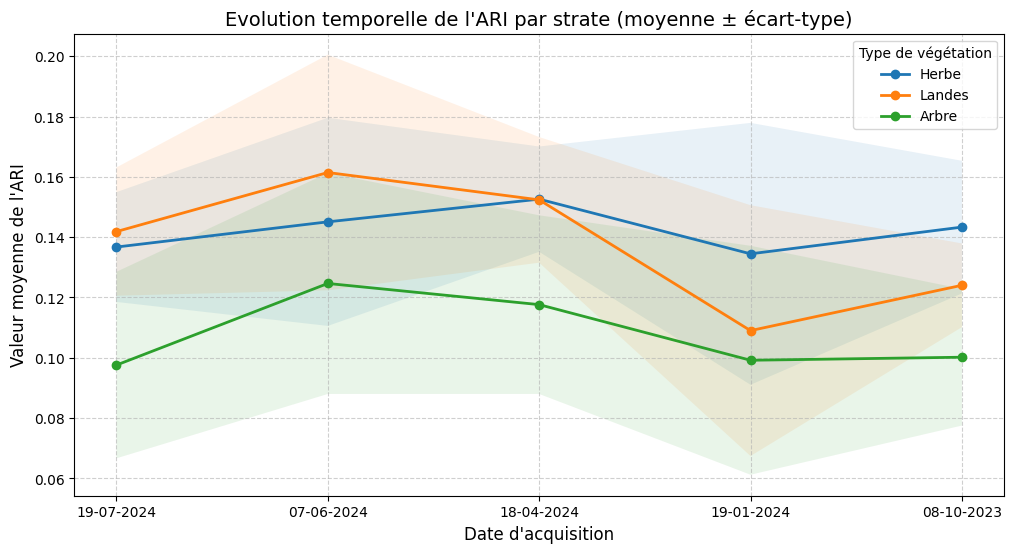

Graphique mis à jour sauvegardé : /home/onyxia/work/results/figure/ARI_series.png


In [ ]:
# --- Statistiques et Visualisation ---

# 1. Définition du dictionnaire de correspondance
noms_strates = {
    2: "Herbe",
    3: "Landes",
    4: "Arbre"
}

output_graphique = os.path.join(figure_path, "ARI_series.png")

# 2. Extraction des échantillons par strate (via cla)
dict_X, Y, dict_t = cla.get_samples_from_roi(
    raster_name=output_ari_path,
    roi_name=output_strates_raster,
    output_fmt='by_label'
)

# 3. Création du graphique
plt.figure(figsize=(12, 6))
x_axis = np.arange(len(dates))

for label, pixels in dict_X.items():
    # On récupère le nom propre via le dictionnaire, sinon on garde le chiffre
    nom_label = noms_strates.get(label, f"Strate {label}")
    
    # Nettoyage NoData et calcul
    valid_pixels = np.where(pixels == -9999, np.nan, pixels)
    means = np.nanmean(valid_pixels, axis=0)
    stds = np.nanstd(valid_pixels, axis=0)
    
    # On utilise nom_label pour la légende
    plt.plot(x_axis, means, label=nom_label, marker='o', linewidth=2)
    plt.fill_between(x_axis, means-stds, means+stds, alpha=0.1)

# Mise en forme finale
plt.xticks(x_axis, dates)
plt.title("Evolution temporelle de l'ARI par strate (moyenne ± écart-type)", fontsize=14)
plt.xlabel("Date d'acquisition", fontsize=12)
plt.ylabel("Valeur moyenne de l'ARI", fontsize=12)
plt.legend(title="Type de végétation")
plt.grid(True, linestyle='--', alpha=0.6)

# Sauvegarde
plt.savefig(output_graphique, dpi=300, bbox_inches='tight')
plt.show()

print(f"Graphique mis à jour sauvegardé : {output_graphique}")

# Production d'une carte de strates à l'échelle du pixel
## Choix du classifieur et sa paramétrisation

In [ ]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier as RF


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import geopandas as gpd
from osgeo import gdal, ogr, osr


In [ ]:
# Charger le fichier de formes (shapefile) avec les classes
gdf = gpd.read_file('/home/onyxia/work/data/projet_eval/PI_strates_bretagne_32630.shp')

# Lire le fichier raster avec les bandes spectrales
dataset = gdal.Open('/home/onyxia/work/results/ARI_serie_temp.tif')
band_count = dataset.RasterCount

# Initialiser les listes pour stocker les données et les étiquettes
X = []
y = []

# Créer un système de coordonnées basé sur EPSG:32630
srs = osr.SpatialReference()
srs.ImportFromEPSG(32630)

# Parcourir chaque polygone dans le shapefile
for index, row in gdf.iterrows():
    # Récupérer la géométrie du polygone
    geom = row['geometry']

    # Créer un masque pour le polygone
    mem_drv = ogr.GetDriverByName('Memory')
    mem_ds = mem_drv.CreateDataSource('out')
    mem_layer = mem_ds.CreateLayer('poly', srs=srs, geom_type=ogr.wkbPolygon)

    # Créer une feature et définir sa géométrie
    feature = ogr.Feature(mem_layer.GetLayerDefn())
    ogr_geom = ogr.CreateGeometryFromWkb(geom.wkb)
    feature.SetGeometry(ogr_geom)
    mem_layer.CreateFeature(feature)
    feature = None

    # Créer un raster en mémoire pour le masque
    target_ds = gdal.GetDriverByName('MEM').Create('', dataset.RasterXSize, dataset.RasterYSize, 1, gdal.GDT_Byte)
    target_ds.SetGeoTransform(dataset.GetGeoTransform())
    target_ds.SetProjection(srs.ExportToWkt())
    band = target_ds.GetRasterBand(1)
    band.Fill(0)
    band.SetNoDataValue(0)

    # Rasteriser le polygone
    gdal.RasterizeLayer(target_ds, [1], mem_layer, burn_values=[1])

    # Lire le masque rasterisé
    mask_array = band.ReadAsArray()

    # Extraire les valeurs des bandes spectrales pour les pixels dans le polygone
    for band_num in range(1, band_count + 1):
        band = dataset.GetRasterBand(band_num)
        band_array = band.ReadAsArray()

        # Extraire les valeurs des pixels qui sont dans le masque
        pixel_values = band_array[mask_array == 1]
        valid_pixels = pixel_values[pixel_values != -9999]

        # Ajouter les valeurs des bandes pour chaque pixel valide
        if band_num == 1:
            X_temp = valid_pixels.reshape(-1, 1)
        else:
            X_temp = np.column_stack((X_temp, valid_pixels))

    # Ajouter les étiquettes de classe pour chaque pixel valide
    if 'X_temp' in locals():
        X.extend(X_temp)
        y.extend([row['strate']] * len(X_temp))

# Convertir X et y en tableaux numpy
X = np.array(X)
y = np.array(y)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print("Forme de X_train:", X_train.shape)
print("Forme de y_train:", y_train.shape)
print("Forme de X_test:", X_test.shape)
print("Forme de y_test:", y_test.shape)


In [ ]:
# Initialiser le modèle RandomForest
rf = RandomForestClassifier(random_state=0)

# Définition de la grille d'hyperparamètres
param_grid = {
    "n_estimators": [50, 100, 150, 200, 300],  # Nombre d'arbres dans la forêt
    "max_depth": [None, 10, 15, 20],     # Profondeur maximale des arbres
    "max_features": [None, "sqrt", "log2"], # Nombre de variables testées à chaque split
    "min_samples_leaf": [1, 5]       # Nombre minimal d’échantillons dans une feuille
}

# Cross-validation stratifiée avec K=5
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# Grille de recherche
grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1  # utilise tous les CPU pour aller plus vite
)

# Entraînement avec recherche des meilleurs hyperparamètres
grid.fit(X_train, y_train)

# Afficher les meilleurs hyperparamètres trouvés
print("Meilleurs hyperparamètres trouvés :")
print(grid.best_params_)

# Score moyen de la cross-validation
print(f"Score CV moyen : {grid.best_score_:.2f}")

# Modèle final (entraîné sur tout le train)
best_model = grid.best_estimator_

# Évaluation sur le test
y_pred = best_model.predict(X_test)
acc_test = accuracy_score(y_test, y_pred)

print(f"Accuracy test : {acc_test:.2f}")

# Afficher un rapport de classification détaillé
from sklearn.metrics import classification_report
print("\nRapport de classification :")
print(classification_report(y_test, y_pred))


**Interprétation des résultats** :

max_depth : 20 : Les arbres ont une profondeur maximale de 20.

max_features : sqrt : Le modèle utilise la racine carrée du nombre total de caractéristiques à chaque division.

min_samples_leaf : 1 : Chaque feuille peut contenir un seul échantillon.

n_estimators : 300 : Le modèle utilise 300 arbres.

---

Classe 2 : Précision de 0.98 et rappel de 0.97.

Classe 3 : Précision de 0.94 et rappel de 0.93.

Classe 4 : Précision de 0.89 et rappel de 0.91.


### Stratégie de validation

Les classes ici sont relativement équilibrées (respectivement 1044, 1545 et 1229 pixels pour les classes 2, 3 et 4). Le type de validation choisi est donc le StratifiedKFold qui permet de conserver la proportion des classes, rendant cette méthode indispensable dans le cas de classes déséquilibrées. Bien que relativement équilibrées, les classes de cette étude ne le sont pas parfaitement. Ainsi, afin d'éviter un biais, le type de validation choisi est le StratifiedKFold. 

Le jeu de données ayant une taille modérée (3818 pixels), la valeur de K choisie est 5, afin que la stratégie de validation soit à la fois robuste et moins coûteuse en temps. 



In [ ]:
# Charger le fichier de formes (shapefile) avec les classes
gdf = gpd.read_file('/home/onyxia/work/data/projet_eval/PI_strates_bretagne_32630.shp')

# Lire le fichier raster avec les bandes spectrales
dataset = gdal.Open('/home/onyxia/work/results/.tif')
band_count = dataset.RasterCount

# Initialiser les listes pour stocker les données et les étiquettes
X = []
y = []

# Créer un système de coordonnées basé sur EPSG:32630
srs = osr.SpatialReference()
srs.ImportFromEPSG(32630)

# Parcourir chaque polygone dans le shapefile
for index, row in gdf.iterrows():
    # Récupérer la géométrie du polygone
    geom = row['geometry']

    # Créer un masque pour le polygone
    mem_drv = ogr.GetDriverByName('Memory')
    mem_ds = mem_drv.CreateDataSource('out')
    mem_layer = mem_ds.CreateLayer('poly', srs=srs, geom_type=ogr.wkbPolygon)

    # Créer une feature et définir sa géométrie
    feature = ogr.Feature(mem_layer.GetLayerDefn())
    ogr_geom = ogr.CreateGeometryFromWkb(geom.wkb)
    feature.SetGeometry(ogr_geom)
    mem_layer.CreateFeature(feature)
    feature = None

    # Créer un raster en mémoire pour le masque
    target_ds = gdal.GetDriverByName('MEM').Create('', dataset.RasterXSize, dataset.RasterYSize, 1, gdal.GDT_Byte)
    target_ds.SetGeoTransform(dataset.GetGeoTransform())
    target_ds.SetProjection(srs.ExportToWkt())
    band = target_ds.GetRasterBand(1)
    band.Fill(0)
    band.SetNoDataValue(0)

    # Rasteriser le polygone
    gdal.RasterizeLayer(target_ds, [1], mem_layer, burn_values=[1])

    # Lire le masque rasterisé
    mask_array = band.ReadAsArray()

    # Extraire les valeurs des bandes spectrales pour les pixels dans le polygone
    for band_num in range(1, band_count + 1):
        band = dataset.GetRasterBand(band_num)
        band_array = band.ReadAsArray()

        # Extraire les valeurs des pixels qui sont dans le masque
        pixel_values = band_array[mask_array == 1]
        valid_pixels = pixel_values[pixel_values != -9999]

        # Ajouter les valeurs des bandes pour chaque pixel valide
        if band_num == 1:
            X_temp = valid_pixels.reshape(-1, 1)
        else:
            X_temp = np.column_stack((X_temp, valid_pixels))

    # Ajouter les étiquettes de classe pour chaque pixel valide
    if 'X_temp' in locals():
        X.extend(X_temp)
        y.extend([row['strate']] * len(X_temp))

# Convertir X et y en tableaux numpy
X = np.array(X)
y = np.array(y)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print("Forme de X_train:", X_train.shape)
print("Forme de y_train:", y_train.shape)
print("Forme de X_test:", X_test.shape)
print("Forme de y_test:", y_test.shape)
